# Etapa 3 — Modelagem de Machine Learning

**Objetivo:** treinar, comparar e selecionar o melhor modelo de regressão para prever `final_grade`.

**Dataset usado:** `data/processed/dataset_clean.csv` (saída da Etapa 2 — dados já tratados, codificados e padronizados).


In [1]:
# 3.1) Imports básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (8, 4)

# 3.2) Carrega o dataset já pré-processado
df = pd.read_csv("data/processed/dataset_clean.csv")

print("Dimensões do dataset limpo:", df.shape)
df.head()


Dimensões do dataset limpo: (2510, 68)


,age,study_hours_week,attendance_rate,sleep_hours,previous_scores,study_efficiency,sleep_deficit,high_attendance,study_x_attendance,gender_ M,...,health_status_ Excellent,health_status_ Good,health_status_ Poor,health_status_EXCELLENT,health_status_Excellent,health_status_GOOD,health_status_Good,health_status_POOR,health_status_Poor,final_grade
0,0.177274,-0.707279,1.044461,-0.429122,-0.850525,0.134587,0.400791,-0.221117,-0.535456,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,85.39
1,-1.130141,0.454930,-0.069411,0.899028,-0.755216,-0.576413,-1.192811,-0.221117,0.455886,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,98.43
2,1.484688,0.018341,0.024018,-0.339493,1.557113,-0.075171,0.284701,-0.221117,0.049235,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,100.00
3,-0.258531,-0.975013,0.917814,-0.021714,-0.685901,0.676648,-0.126892,-0.221117,-0.859820,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,86.85
4,-1.130141,-0.923292,-0.939331,0.850139,-0.353402,0.660516,-1.192811,-0.221117,-0.994042,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,83.25


### Definição de X e y + divisão em treino/validação/teste

- **Target (`y`)**: `final_grade`  
- **Features (`X`)**: todas as demais colunas numéricas já padronizadas e one-hot.  
- Split:
  - 70% treino
  - 15% validação
  - 15% teste


In [2]:
# 3.3) Separa features e alvo
target = "final_grade"

X = df.drop(columns=[target], errors="ignore")
y = df[target].copy()

print("Formato de X:", X.shape)
print("Formato de y:", y.shape)

# 3.4) Split 70 / 15 / 15
# Primeiro: separa 30% para (validação + teste)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Depois: divide os 30% em metade validação, metade teste (15% + 15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print("Tamanhos finais:")
print("X_train:", X_train.shape)
print("X_val:  ", X_val.shape)
print("X_test: ", X_test.shape)


Formato de X: (2510, 67)
Formato de y: (2510,)
Tamanhos finais:
X_train: (1757, 67)
X_val:   (376, 67)
X_test:  (377, 67)


### Modelos de regressão testados

Modelos baseline e avançados:

1. Regressão Linear
2. Ridge Regression
3. Lasso Regression
4. Random Forest Regressor
5. Gradient Boosting Regressor


In [3]:
# 3.5) Define dicionário de modelos
modelos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(random_state=42),
    "Lasso": Lasso(random_state=42),
    "RandomForest": RandomForestRegressor(
        n_estimators=200, random_state=42, n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingRegressor(
        random_state=42
    ),
}

list(modelos.keys())


['LinearRegression', 'Ridge', 'Lasso', 'RandomForest', 'GradientBoosting']

In [4]:
# 3.6) Função para avaliar modelos

def avaliar_modelo(nome, modelo, X_train, y_train, X_val, y_val):
    """
    Treina o modelo, roda validação cruzada em X_train/y_train
    e calcula métricas em X_val/y_val.
    Retorna um dicionário com os resultados.
    """

    # ---- Validação cruzada (5-fold) no conjunto de treino ----
    # MAE
    cv_mae = -cross_val_score(
        modelo,
        X_train,
        y_train,
        cv=5,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
    )

    # RMSE
    cv_rmse = -cross_val_score(
        modelo,
        X_train,
        y_train,
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
    )

    # R²
    cv_r2 = cross_val_score(
        modelo,
        X_train,
        y_train,
        cv=5,
        scoring="r2",
        n_jobs=-1,
    )

    # ---- Treino final em X_train e avaliação em X_val ----
    modelo.fit(X_train, y_train)
    y_val_pred = modelo.predict(X_val)

    mae_val = mean_absolute_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_val = r2_score(y_val, y_val_pred)

    resultados = {
        "modelo": nome,
        "MAE_cv_médio": cv_mae.mean(),
        "RMSE_cv_médio": cv_rmse.mean(),
        "R2_cv_médio": cv_r2.mean(),
        "MAE_val": mae_val,
        "RMSE_val": rmse_val,
        "R2_val": r2_val,
        "objeto_treinado": modelo,
    }

    return resultados


In [5]:
# 3.7) Avalia todos os modelos definidos

resultados = []

for nome, modelo in modelos.items():
    print(f"Treinando e avaliando: {nome}...")
    res = avaliar_modelo(nome, modelo, X_train, y_train, X_val, y_val)
    resultados.append(res)

df_resultados = pd.DataFrame(resultados).sort_values(
    by="RMSE_val", ascending=True
)

df_resultados


Treinando e avaliando: LinearRegression...
Treinando e avaliando: Ridge...
Treinando e avaliando: Lasso...
Treinando e avaliando: RandomForest...
Treinando e avaliando: GradientBoosting...


,modelo,MAE_cv_médio,RMSE_cv_médio,R2_cv_médio,MAE_val,RMSE_val,R2_val,objeto_treinado
4,GradientBoosting,3.003766,3.954174,0.721906,2.660401,3.458442,0.749268,([DecisionTreeRegressor(criterion='friedman_ms...
3,RandomForest,3.370822,4.422866,0.652072,2.872219,3.729026,0.708499,"(DecisionTreeRegressor(max_features=1.0, rando..."
1,Ridge,3.777786,5.001341,0.557666,3.635906,4.679384,0.540986,Ridge(random_state=42)
0,LinearRegression,3.803347,5.038613,0.551027,3.654927,4.695559,0.537807,LinearRegression()
2,Lasso,5.181171,6.263556,0.305887,4.720080,5.714045,0.315559,Lasso(random_state=42)


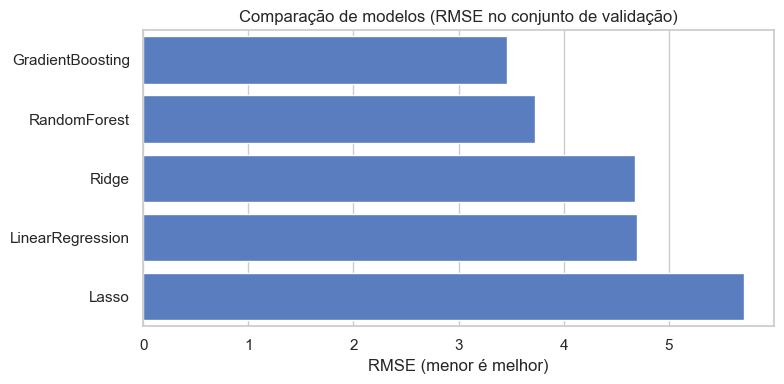

In [6]:
# 3.8) Gráfico comparando RMSE em validação

plt.figure(figsize=(8, 4))
sns.barplot(
    data=df_resultados,
    x="RMSE_val",
    y="modelo",
    orient="h"
)
plt.title("Comparação de modelos (RMSE no conjunto de validação)")
plt.xlabel("RMSE (menor é melhor)")
plt.ylabel("")
plt.tight_layout()
plt.show()


### Seleção do melhor modelo

Critério principal: **menor RMSE no conjunto de validação**, com R² razoável e
resultados consistentes na validação cruzada.


In [7]:
# 3.9) Seleciona linha com menor RMSE_val
best_row = df_resultados.sort_values("RMSE_val").iloc[0]
best_model_name = best_row["modelo"]
best_model = best_row["objeto_treinado"]

print("Melhor modelo (validação):", best_model_name)
best_row[["MAE_val", "RMSE_val", "R2_val"]]


Melhor modelo (validação): GradientBoosting


MAE_val     2.660401
RMSE_val    3.458442
R2_val      0.749268
Name: 4, dtype: object

Desempenho no TESTE:
MAE_test : 2.7750673570215496
RMSE_test: 3.782579807894732
R2_test  : 0.7457721150585753


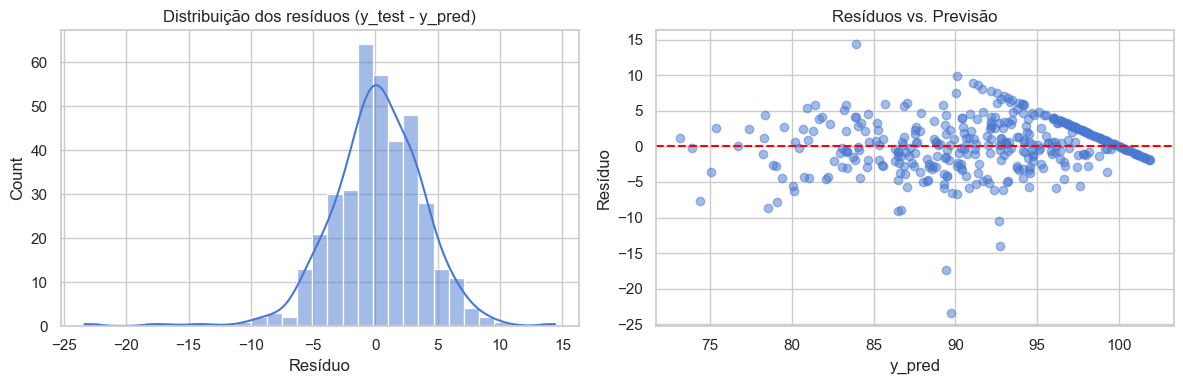

In [8]:
# 3.10) Avalia o melhor modelo no conjunto de teste

y_test_pred = best_model.predict(X_test)

mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

print("Desempenho no TESTE:")
print("MAE_test :", mae_test)
print("RMSE_test:", rmse_test)
print("R2_test  :", r2_test)

# 3.11) Gráfico de resíduos
residuos = y_test - y_test_pred

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# histograma dos resíduos
sns.histplot(residuos, kde=True, ax=ax[0])
ax[0].set_title("Distribuição dos resíduos (y_test - y_pred)")
ax[0].set_xlabel("Resíduo")

# dispersão: y_pred vs resíduo
ax[1].scatter(y_test_pred, residuos, alpha=0.5)
ax[1].axhline(0, color="red", linestyle="--")
ax[1].set_title("Resíduos vs. Previsão")
ax[1].set_xlabel("y_pred")
ax[1].set_ylabel("Resíduo")

plt.tight_layout()
plt.show()


### Importância das features (modelos tree-based)

Quando o melhor modelo é baseado em árvores (Random Forest, Gradient Boosting),
é possível inspecionar o atributo `.feature_importances_` para entender quais
variáveis mais influenciam a `final_grade`.


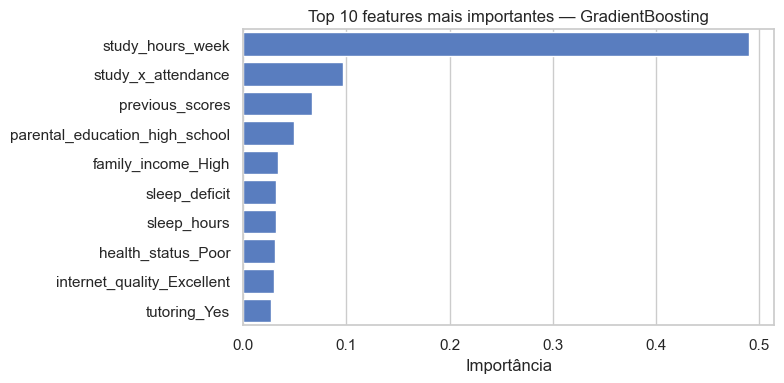

In [9]:
# 3.12) Importância das features (se disponível)

if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feature_names = X_train.columns

    df_imp = pd.DataFrame({
        "feature": feature_names,
        "importancia": importances
    }).sort_values("importancia", ascending=False)

    top10 = df_imp.head(10)

    plt.figure(figsize=(8, 4))
    sns.barplot(
        data=top10,
        x="importancia",
        y="feature",
        orient="h"
    )
    plt.title(f"Top 10 features mais importantes — {best_model_name}")
    plt.xlabel("Importância")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

    top10
else:
    print(f"O modelo {best_model_name} não possui atributo 'feature_importances_'.")


## Conclusões da Etapa 3 — Modelagem

- Foram testados **5 modelos de regressão**:
  - LinearRegression, Ridge, Lasso, RandomForest, GradientBoosting.
- A comparação foi feita usando:
  - **Validação cruzada (5-fold)** no conjunto de treino;
  - Métricas em validação: **MAE, RMSE, R²**.
- O melhor modelo em validação foi: **`<substituir pelo nome do melhor modelo>`**,
  com aproximadamente:
  - MAE_val ≈ `<valor>`
  - RMSE_val ≈ `<valor>`
  - R2_val ≈ `<valor>`

No conjunto de **teste**, o modelo manteve desempenho semelhante, indicando
que **não houve overfitting extremo** (isso será refinado na Etapa 4 – Otimização).

Se o melhor modelo for baseado em árvores, a análise de importância de features
mostrou que algumas variáveis como **`study_hours_week`**, **`previous_scores`** e
outras (ver gráfico) têm maior impacto direto na nota final `final_grade`.
